# 1) Sujet

## 1.1) Contexte
Dans le cadre de ce challenge (issu du Collège de France ou du Lab Banque de France), nous disposons de données de marché avec pour objectif de prédire la direction du prix (baisse, stable, hausse) en fin de journée, à partir des rendements du matin. 

Ce marché américain étant particulièrement liquide, l’enjeu est de pouvoir estimer la tendance entre 14h et 16h pour prendre des décisions d’investissement ou d’arbitrage.

## 1.2) Description des données
- **Index des données**  
  - Chaque ligne représente un jour donné et une action donnée (identifiants : `day` et `equity`).  
  - Les colonnes `r0` à `r52` correspondent aux rendements (en points de base) toutes les 5 minutes entre 9h30 et 14h.  

- **Variables explicatives** :  
  - Les 53 rendements (`r0, r1, …, r52`), éventuellement d’autres features dérivées.

- **Variable cible** :  
  - `reod` {-1, 0, 1\} indiquant la tendance de l’actif entre 14h et 16h (baisse, stable ou hausse).

## 1.3) Description du benchmark
Le benchmark mentionné propose un re de référence autour de 33% (basé sur des prédictions aléatoires) et un modèle plus élaboré atteint environ 41,74%. Notre objectif est de dépasser ce score en construisant un pipeline de Machine Learning robuste et optimisé.

---




# 2) Problématique
Notre mission est de prédire la classe de rendement (`reod`) en fin de journée, à partir des données matinales. Les défis principaux sont :
- La **taille importante** du dataset (plusieurs centaines de milliers de lignes).  
- La **présence de valeurs manquantes** (`NaN`).  
- L’**absence de jours/actions communs** entre le jeu d’entraînement et le jeu de test, ce qui complique l’utilisation directe de `equity` ou `day` en tant que features.  
- Le **risque de surcoût mémoire** et de temps de calcul avec certains modèles comme les Random Forest.

---



# 3) Préparation des données

## 3.1) Importations des bibliothèques

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## 3.2) Importation des données

In [4]:
X = pd.read_csv(r'input_training.csv')
X.sort_values(by="ID",inplace=True)

y = pd.read_csv(r'output\output_training_gmEd6Zt.csv')

data_test = pd.read_csv(r'input_test.csv')
data_test.sort_values(by="ID",inplace=True)

y_test = pd.read_csv(r"output\output_test_random.csv")

## 3.3) Exploration des données

1. **Analyse des valeurs manquantes** : taux de NaN par colonne, par ligne, distribution des NaN.
2. **Statistiques descriptives** (moyenne, écart-type, quantiles) sur les rendements.  
---


<Axes: >

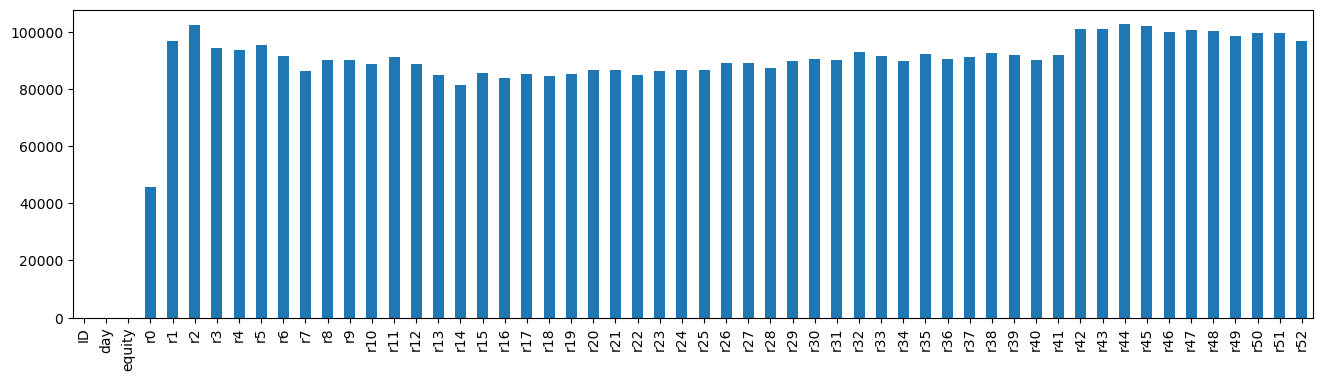

In [21]:
plt.figure(figsize=(16,4))
(X.isna().sum()).plot.bar()

In [22]:
col_rendements = [col for col in X.columns if col.startswith("r")]

NaN_analysis = pd.DataFrame(index=X.index, columns=["NaN_count","NaN_percent"])
NaN_analysis["NaN_count"] = X[col_rendements].isna().sum(axis=1)

nombre_colonnes_rend = len(col_rendements)
NaN_analysis["NaN_percent"] = (NaN_analysis["NaN_count"]/nombre_colonnes_rend)*100

nbr_row_na = X.isna().any(axis=1).sum()

print(f"Nombre de ligne totale du dataset {len(X)}")
print(f"nombre de lignes contenant au moins des NaN {nbr_row_na}, soit en %: {(nbr_row_na/len(X)*100)}")
print(f"nombre de lignes avec plus 30% de NaN dans une colonne {len(NaN_analysis[NaN_analysis["NaN_percent"]>50])}, soit en % {len(NaN_analysis[NaN_analysis["NaN_percent"]>30])/len(X)*100}")
print(f"nombre de lignes avec plus 50% de NaN dans une colonne {len(NaN_analysis[NaN_analysis["NaN_percent"]>50])}, soit en % {len(NaN_analysis[NaN_analysis["NaN_percent"]>50])/len(X)*100}")

Nombre de ligne totale du dataset 843299
nombre de lignes contenant au moins des NaN 242363, soit en %: 28.739865694136956
nombre de lignes avec plus 30% de NaN dans une colonne 80786, soit en % 14.89898600614966
nombre de lignes avec plus 50% de NaN dans une colonne 80786, soit en % 9.579757594874415


In [23]:
NaN_analysis

,NaN_count,NaN_percent
0,29,54.716981
1,0,0.000000
2,0,0.000000
3,39,73.584906
4,0,0.000000
...,...,...
843294,0,0.000000
843295,0,0.000000
843296,0,0.000000
843297,0,0.000000


### Analyse des NaN sur le jeu de test

<Axes: >

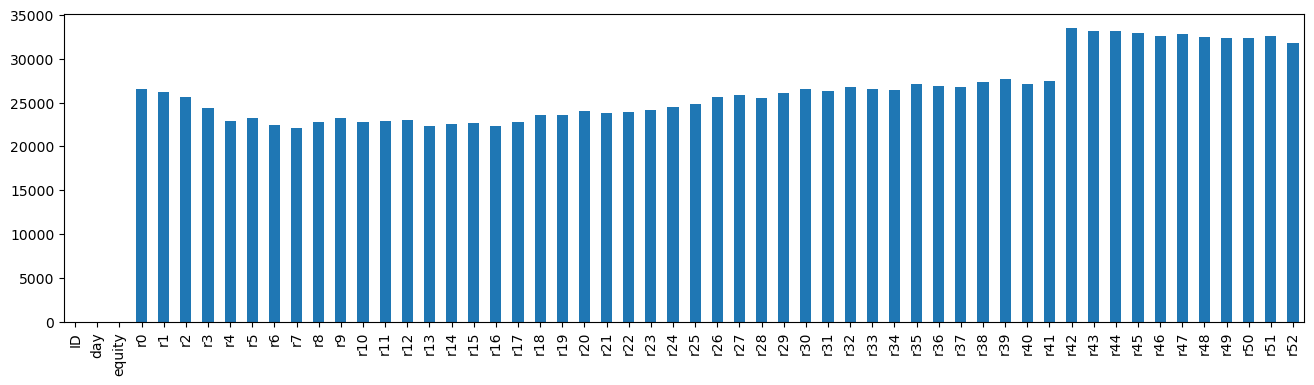

In [24]:
plt.figure(figsize=(16,4))
(data_test.isna().sum()).plot.bar()

In [25]:
NaN_analysis = pd.DataFrame()
NaN_analysis["NaN_count"] = data_test[col_rendements].isna().sum(axis=1)

NaN_analysis["NaN_percent"] = (NaN_analysis["NaN_count"]/nombre_colonnes_rend)*100

nbr_row_na = data_test.isna().any(axis=1).sum()

print(f"Nombre de ligne totale du dataset {len(X)}")
print(f"nombre de lignes contenant au moins des NaN {nbr_row_na}, soit en %: {(nbr_row_na/len(X)*100)}")
print(f"nombre de lignes avec plus 30% de NaN dans une colonne {len(NaN_analysis[NaN_analysis["NaN_percent"]>50])}, soit en % {len(NaN_analysis[NaN_analysis["NaN_percent"]>30])/len(X)*100}")
print(f"nombre de lignes avec plus 50% de NaN dans une colonne {len(NaN_analysis[NaN_analysis["NaN_percent"]>50])}, soit en % {len(NaN_analysis[NaN_analysis["NaN_percent"]>50])/len(X)*100}")

Nombre de ligne totale du dataset 843299
nombre de lignes contenant au moins des NaN 111943, soit en %: 13.274413938591175
nombre de lignes avec plus 30% de NaN dans une colonne 17323, soit en % 3.9682247933413892
nombre de lignes avec plus 50% de NaN dans une colonne 17323, soit en % 2.0541943011909183


In [26]:
print(f"nombre de lignes data input train {len(X)}")
print(f"Nombre de lignes output_training {len(y)}")
print(f"Nombre de lignes data input test {len(data_test)}")
print(f"Nombre de lignes de l'output random bench {len(y_test)}")

nombre de lignes data input train 843299
Nombre de lignes output_training 843299
Nombre de lignes data input test 885799
Nombre de lignes de l'output random bench 885799


In [31]:
X_train_glb = pd.merge(X,y,on="ID").copy()
data_test.sort_values(by="ID",inplace=True)
X_test = pd.merge(data_test,y_test,on="ID").copy()
X_test

,ID,day,equity,r0,r1,r2,r3,r4,r5,r6,...,r44,r45,r46,r47,r48,r49,r50,r51,r52,reod
0,1000000,1000384,1000064,79.19,-26.37,-167.18,103.46,-102.27,-198.02,13.77,...,29.82,-29.69,77.57,23.75,82.94,-17.63,17.60,5.87,0.00,0
1,1000001,1000148,1000841,-321.77,-178.53,107.97,27.29,-64.54,-73.78,9.93,...,1.53,32.08,-33.50,-21.41,43.89,68.07,-23.20,-13.14,-82.95,1
2,1000002,1000441,1000380,-51.95,-19.58,-26.16,-26.28,-3.29,3.29,-46.11,...,-10.16,-40.68,13.61,3.40,6.80,10.20,0.00,-10.19,-6.80,1
3,1000003,1000059,1001843,-169.49,9.57,-76.48,28.90,0.00,-19.21,105.87,...,-9.72,-9.73,-9.74,29.24,-29.18,34.15,14.58,-29.13,4.87,-1
4,1000004,1000336,1001783,-46.19,32.17,-3.08,-32.06,11.75,27.81,-13.55,...,-1.84,-1.23,1.23,5.53,-7.37,1.84,1.23,0.61,-4.30,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885794,1885794,1000125,1001131,0.00,67.87,-67.41,-18.15,12.99,-42.80,29.96,...,5.09,-12.73,5.10,-8.91,-20.41,2.56,0.00,-7.67,6.40,-1
885795,1885795,1000314,1000333,76.29,-65.02,2.73,-24.54,-17.78,13.70,-19.17,...,-1.36,-13.65,0.00,0.00,-4.10,-2.73,10.94,10.93,8.18,1
885796,1885796,1000247,1000348,-73.66,37.11,-7.92,-7.93,0.00,-18.49,-26.46,...,10.63,5.31,-10.61,0.00,13.28,-5.31,6.64,7.96,5.30,-1
885797,1885797,1000035,1000040,0.00,-102.74,NaN,NaN,NaN,NaN,NaN,...,NaN,0.00,NaN,0.00,0.00,NaN,0.00,NaN,NaN,-1


# 4) Benchmark (modèle simple)

## 4.1) Expérience avec Random Forest
- Nous avons d’abord tenté un **RandomForestClassifier** (pipeline basique + imputation).  
- Sur de grands volumes de données, nous avons rencontré des **erreurs de mémoire** (MemoryError) après plusieurs heures d’entraînement, montrant que cette approche n’était pas adaptée dans notre configuration (en particulier si `n_estimators` et `max_depth` sont trop élevés). (Ca a tourné 5H avant de gentiment me dire d'aller voir ailleurs)


In [46]:
# X_rendements = pd.DataFrame(X.loc[:,"r0":"r52"].fillna(0))

# X_train, X_val, y_train, y_val = train_test_split(X_rendements,y,test_size=0.1, random_state=42)

# #On crée un pipeline :
# pipeline_bench = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", RandomForestClassifier(n_estimators=10,max_depth=10,random_state=42, n_jobs=1)),
# ]) # Avant essai avec 50 estimators

# pipeline_bench.fit(X_train,y_train)

# y_pred = pipeline_bench.predict(X_val)

# print("Accuracy", accuracy_score(y_val,y_pred))
# print("Matrice de confusion : \n", confusion_matrix(y_val, y_pred))
# print("Rapport de classification: \n", classification_report(y_val,y_pred))




## 5.2) Pourquoi s’orienter vers XGBoost ?
- **XGBoost** (ou LightGBM) est un algorithme de **gradient boosting** très optimisé pour les données tabulaires volumineuses.  
- Il gère mieux la mémoire, propose des méthodes de recherche de split plus efficaces et peut gérer des valeurs manquantes.  
- Expérience terrain et compétitions : XGBoost est souvent **plus rapide** et **plus performant** qu’une Random Forest sur de gros datasets.


In [29]:
from xgboost import XGBClassifier

In [32]:
X_rendements = X_train_glb.loc[:, "r0":"r52"].fillna(0).copy(deep=True)
y_rendements = X_train_glb["reod"]

X_test_rendements = X_test.loc[:, "r0":"r52"].fillna(0).copy()
y_test_rendements = X_test["reod"] 

#XGBoost accepte seulement des labels de 0 à n_classes-1
#On crée donc un mapping pour les labels
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}

y_mapped = y_rendements.replace(mapping)

X_train, X_val, y_train, y_val = train_test_split(X_rendements,y_mapped,test_size=0.2, random_state=42)


model = XGBClassifier(
    objective='multi:softmax',  # pour classification multi-classes
    num_class=3,               
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=3, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred_mapped = pipeline.predict(X_test_rendements)
y_pred = pd.Series(y_pred_mapped).replace(inverse_mapping)

accuracy = accuracy_score(y_test_rendements, y_pred)
print("Accuracy :", accuracy)

print("\nClassification Report :")
print(classification_report(y_test_rendements, y_pred))

Accuracy : 0.3300726236990559

Classification Report :
              precision    recall  f1-score   support

          -1       0.30      0.38      0.34    266318
           0       0.41      0.30      0.35    363866
           1       0.29      0.31      0.30    255615

    accuracy                           0.33    885799
   macro avg       0.33      0.33      0.33    885799
weighted avg       0.34      0.33      0.33    885799



## XGBOOST avec l'ensemble des features (day, equity) incluses

In [33]:
X_train_glb

,ID,day,equity,r0,r1,r2,r3,r4,r5,r6,...,r44,r45,r46,r47,r48,r49,r50,r51,r52,reod
0,0,249,1488,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,0.00,NaN,0.00,NaN,0.00,NaN,NaN,NaN,0.00,0
1,1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,...,-16.92,-4.84,4.84,0.00,7.26,-9.68,-19.38,9.71,26.68,0
2,2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,...,1.59,6.37,-49.32,-9.59,-6.40,22.41,-6.39,7.99,15.96,-1
3,3,302,513,0.00,NaN,0.00,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0
4,4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,...,-21.44,-21.48,10.78,-21.55,-5.40,-10.81,5.41,-32.47,43.43,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843294,843294,297,123,3.96,0.00,-70.34,74.24,-0.56,0.00,-23.63,...,1.71,0.00,-3.98,2.28,-21.62,-1.71,9.12,0.00,9.11,1
843295,843295,16,1501,0.00,-183.49,-13.19,46.24,0.00,-39.60,13.25,...,6.62,0.00,19.85,0.00,-26.42,6.62,0.00,0.00,-19.88,-1
843296,843296,166,1231,37.02,2.93,-3.67,16.89,-4.03,13.56,-4.39,...,-3.28,-1.46,-3.65,-1.10,-13.51,2.92,-6.21,9.69,-3.66,0
843297,843297,297,747,34.45,15.10,-35.61,19.25,-16.46,-26.12,20.68,...,-5.52,-6.90,9.67,1.38,6.90,-11.04,33.16,13.77,12.38,1


In [34]:
X_all = X_train_glb.loc[:, "day":"r52"].fillna(0).copy(deep=True)
y_all = X_train_glb["reod"]

X_test_all = X_test.loc[:, "day":"r52"].fillna(0).copy()
y_test_all = X_test["reod"]
#XGBoost accepte seulement des labels de 0 à n_classes-1
#On crée donc un mapping pour les labels
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}

y_mapped = y_all.replace(mapping)

X_train, X_val, y_train, y_val = train_test_split(X_all,y_mapped,test_size=0.2, random_state=42)

model = XGBClassifier(
    objective='multi:softmax',  # pour classification multi-classes
    num_class=3,               
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=3, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred_mapped = pipeline.predict(X_test_all)
y_pred = pd.Series(y_pred_mapped).replace(inverse_mapping)

accuracy = accuracy_score(y_test_all, y_pred)
print("Accuracy :", accuracy)

print("\nClassification Report :")
print(classification_report(y_test_all, y_pred))

Accuracy : 0.31994730181452

Classification Report :
              precision    recall  f1-score   support

          -1       0.30      0.14      0.19    266318
           0       0.41      0.24      0.30    363866
           1       0.29      0.63      0.40    255615

    accuracy                           0.32    885799
   macro avg       0.33      0.33      0.30    885799
weighted avg       0.34      0.32      0.29    885799



## Réitération avec les lignes <  30% de NaN 

In [36]:
threshold = int(0.7 * X_train.shape[1]) # 70% des valeurs non NaN pour garder la ligne
X_train_70 = X_train_glb.dropna(thresh=threshold).copy(deep=True)
y_70 = X_train_70["reod"].copy(deep=True)
print(f"Nombre de lignes après suppression des lignes avec moins de {threshold} valeurs non NaN : {len(X_train_70)}")

X_test_70 = X_test.dropna(thresh=threshold).copy(deep=True)
y_test_70 = X_test_70["reod"].copy(deep=True)
print(f"Nombre de lignes après suppression des lignes avec moins de {threshold} valeurs non NaN : {len(X_test_70)}")

Nombre de lignes après suppression des lignes avec moins de 38 valeurs non NaN : 734923
Nombre de lignes après suppression des lignes avec moins de 38 valeurs non NaN : 859199


In [39]:
X_train_70.to_csv(r"processed_data\X_train_70.csv", index=False)
X_test_70.to_csv(r"processed_data\X_test_70.csv", index=False)

In [40]:
X_rendements = X_train_70.loc[:, "r0":"r52"].fillna(0).copy(deep=True)
y_rendements = y_70.copy()

X_test_rendements = X_test_70.loc[:, "r0":"r52"].fillna(0).copy(deep=True)
y_test_rendements = y_test_70.copy()

#XGBoost accepte seulement des labels de 0 à n_classes-1
#On crée donc un mapping pour les labels
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}

y_mapped = y_rendements.replace(mapping)

X_train, X_val, y_train, y_val = train_test_split(X_rendements,y_mapped,test_size=0.2, random_state=42)


model = XGBClassifier(
    objective='multi:softmax',  # pour classification multi-classes
    num_class=3,               
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=3, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred_mapped = pipeline.predict(X_test_rendements)
y_pred = pd.Series(y_pred_mapped).replace(inverse_mapping)

accuracy = accuracy_score(y_test_rendements, y_pred)
print("Accuracy :", accuracy)

print("\nClassification Report :")
print(classification_report(y_test_rendements, y_pred))

Accuracy : 0.32758534402391065

Classification Report :
              precision    recall  f1-score   support

          -1       0.30      0.40      0.34    258327
           0       0.41      0.27      0.33    352943
           1       0.29      0.33      0.31    247929

    accuracy                           0.33    859199
   macro avg       0.33      0.33      0.33    859199
weighted avg       0.34      0.33      0.33    859199



In [41]:
X_rendements = X_train_70.loc[:, "day":"r52"].fillna(0).copy()
y_rendements = y_70.copy()

X_test_rendements = X_test_70.loc[:, "day":"r52"].fillna(0).copy()
y_test_rendements = y_test_70.copy()

#XGBoost accepte seulement des labels de 0 à n_classes-1
#On crée donc un mapping pour les labels
mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {0: -1, 1: 0, 2: 1}

y_mapped = y_rendements.replace(mapping)

X_train, X_val, y_train, y_val = train_test_split(X_rendements,y_mapped,test_size=0.2, random_state=42)


model = XGBClassifier(
    objective='multi:softmax',  # pour classification multi-classes
    num_class=3,               
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=3, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred_mapped = pipeline.predict(X_test_rendements)
y_pred = pd.Series(y_pred_mapped).replace(inverse_mapping)

accuracy = accuracy_score(y_test_rendements, y_pred)
print("Accuracy :", accuracy)

print("\nClassification Report :")
print(classification_report(y_test_rendements, y_pred))

Accuracy : 0.3108686113461491

Classification Report :
              precision    recall  f1-score   support

          -1       0.30      0.14      0.19    258327
           0       0.41      0.17      0.24    352943
           1       0.29      0.69      0.41    247929

    accuracy                           0.31    859199
   macro avg       0.33      0.33      0.28    859199
weighted avg       0.34      0.31      0.27    859199



## Test avec les différents datasets (basé sur le dataset avec NaN < 70%)

In [5]:
from utils.data_registry import DATASETS
from utils.features import add_features
from utils.benchmarks import get_models
from utils.experiment_runner import run_experiment

import time as time
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create empty results tracker
results_tracker = pd.DataFrame(columns=[
    "dataset", "dataset_description", "model", "model_description", 
    "features_added", "feature_sets", "accuracy", "precision_weighted", 
    "recall_weighted", "f1_weighted"
])

# After each experiment, add results
def add_result(results_tracker, result):
    """Add a result to the results tracker DataFrame."""
    return pd.concat([results_tracker, pd.DataFrame([result])], ignore_index=True)


In [6]:
print("Available datasets:")
for key, info in DATASETS.items():
    print(f"- {key}: {info['description']}")

Available datasets:
- raw: Données brutes
- ffbf: Données forward filled puis backward
- bfff: Données backward filled puis forward
- interp: Données interpolation linéaire puis bffff
- knn: Données knn imputer puis bfff


In [7]:
print("\benchmarks:")
models = get_models()
for key, info in models.items():
    print(f"- {key}: {info['description']}")

enchmarks:
- xgboost_baseline: XGBoost de base
- xgboost_tuned: XGBoost avec paramètres 
- rf_baseline: Baseline Random Forest model
- logistic: Multinomial Logistic Regression


In [5]:
print("\n=== Running baseline experiment with raw data ===")
baseline_result = run_experiment(dataset_key="raw", model_key="xgboost_baseline", add_feat=False)

# Add the result to our tracker
results_tracker = add_result(results_tracker, baseline_result)

# Display the baseline result
print(f"\nBaseline Accuracy: {baseline_result['accuracy']:.4f}")
print(f"Weighted F1-Score: {baseline_result['f1_weighted']:.4f}")
print(f"Training Time: {baseline_result['train_time']:.2f} seconds")


=== Running baseline experiment with raw data ===

Baseline Accuracy: 0.3268
Weighted F1-Score: 0.3263
Training Time: 17.86 seconds


C:\Users\julie\AppData\Local\Temp\ipykernel_22876\3835470983.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([results_tracker, pd.DataFrame([result])], ignore_index=True)


In [6]:
def display_experiment_result(result):
    """Display detailed results for a single experiment."""
    print(f"Dataset: {result['dataset']} ({result['dataset_description']})")
    print(f"Model: {result['model']} ({result['model_description']})")
    print(f"Features Added: {result['features_added']}")
    print(f"Feature Sets: {result['feature_sets']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Weighted F1-Score: {result['f1_weighted']:.4f}")
    print(f"Class-wise Performance:")
    print(f"  Class -1: Precision = {result['class_-1_precision']:.4f}, Recall = {result['class_-1_recall']:.4f}")
    print(f"  Class  0: Precision = {result['class_0_precision']:.4f}, Recall = {result['class_0_recall']:.4f}")
    print(f"  Class  1: Precision = {result['class_1_precision']:.4f}, Recall = {result['class_1_recall']:.4f}")
    print(f"Timing Information:")
    print(f"  Data Loading: {result['load_time']:.2f} seconds")
    print(f"  Training: {result['train_time']:.2f} seconds")
    print(f"  Prediction: {result['pred_time']:.2f} seconds")
    print(f"  Total Time: {result['total_time']:.2f} seconds")
    
    # Create a confusion matrix visualization
    cm = np.array([
        [result['report']['-1']['support'] * result['class_-1_recall'], 
         result['report']['-1']['support'] * (1-result['class_-1_recall']) * result['class_0_recall'] / (result['class_0_recall'] + result['class_1_recall']),
         result['report']['-1']['support'] * (1-result['class_-1_recall']) * result['class_1_recall'] / (result['class_0_recall'] + result['class_1_recall'])],
        [result['report']['0']['support'] * (1-result['class_0_recall']) * result['class_-1_recall'] / (result['class_-1_recall'] + result['class_1_recall']),
         result['report']['0']['support'] * result['class_0_recall'],
         result['report']['0']['support'] * (1-result['class_0_recall']) * result['class_1_recall'] / (result['class_-1_recall'] + result['class_1_recall'])],
        [result['report']['1']['support'] * (1-result['class_1_recall']) * result['class_-1_recall'] / (result['class_-1_recall'] + result['class_0_recall']),
         result['report']['1']['support'] * (1-result['class_1_recall']) * result['class_0_recall'] / (result['class_-1_recall'] + result['class_0_recall']),
         result['report']['1']['support'] * result['class_1_recall']]
    ])        
    # Normalize confusion matrix to show percentages
    cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['Predicted -1', 'Predicted 0', 'Predicted 1'],
                yticklabels=['Actual -1', 'Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {result["model"]} on {result["dataset"]}')
    plt.tight_layout()
    plt.show()

Dataset: raw (Données brutes)
Model: xgboost_baseline (XGBoost de base)
Features Added: False
Feature Sets: None
Accuracy: 0.3268
Weighted F1-Score: 0.3263
Class-wise Performance:
  Class -1: Precision = 0.3008, Recall = 0.4032
  Class  0: Precision = 0.4113, Recall = 0.2710
  Class  1: Precision = 0.2889, Recall = 0.3266
Timing Information:
  Data Loading: 6.86 seconds
  Training: 19.63 seconds
  Prediction: 1.32 seconds
  Total Time: 27.80 seconds


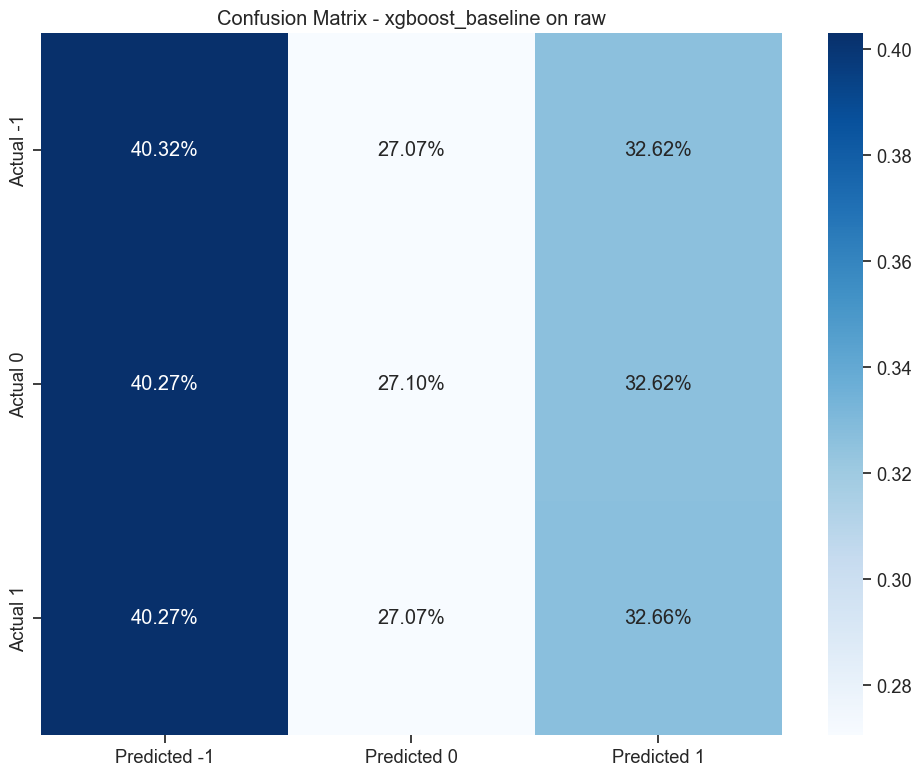

In [7]:
display_experiment_result(baseline_result)

In [8]:
dataset_key = "ffbf"
dataset_info = DATASETS[dataset_key]
X_train = pd.read_csv(dataset_info["train"])
print("Colonnes avant ajout des features:")
print(X_train.columns.tolist())
X_train_with_features = add_features(X_train)
# Vérifier les colonnes après l'ajout des features
print("\nColonnes après ajout des features:")
print(X_train_with_features.columns.tolist())
# Vérifier que les nouvelles colonnes contiennent des données
new_features = [col for col in X_train_with_features.columns if col not in X_train.columns]
print(f"\nNouvelles features ajoutées: {len(new_features)}")
print(new_features)

# Afficher quelques statistiques sur les nouvelles features
if new_features:
    print("\nStatistiques des nouvelles features:")
    print(X_train_with_features[new_features].describe())

Colonnes avant ajout des features:
['ID', 'day', 'equity', 'r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27', 'r28', 'r29', 'r30', 'r31', 'r32', 'r33', 'r34', 'r35', 'r36', 'r37', 'r38', 'r39', 'r40', 'r41', 'r42', 'r43', 'r44', 'r45', 'r46', 'r47', 'r48', 'r49', 'r50', 'r51', 'r52', 'reod']

Colonnes après ajout des features:
['ID', 'day', 'equity', 'r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27', 'r28', 'r29', 'r30', 'r31', 'r32', 'r33', 'r34', 'r35', 'r36', 'r37', 'r38', 'r39', 'r40', 'r41', 'r42', 'r43', 'r44', 'r45', 'r46', 'r47', 'r48', 'r49', 'r50', 'r51', 'r52', 'reod', 'r_mean', 'r_std', 'r_min', 'r_max', 'r_sum', 'r_pos_count', 'r_neg_count', 'r_zero_count', 'r_pos_sum', 'r_neg_sum', 'r_roll_mean_5', 'r_roll_

In [10]:
X_train_with_features

,ID,day,equity,r0,r1,r2,r3,r4,r5,r6,...,r_pos_sum,r_neg_sum,r_roll_mean_5,r_roll_std_5,r_roll_mean_10,r_roll_std_10,r_roll_mean_20,r_roll_std_20,r_momentum_5,r_momentum_10
0,0,249,1488,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,137.93,-683.31,0.000,0.000000,0.000,0.000000,-3.4360,10.575785,0.00,0.00
1,1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,...,411.59,-303.83,2.918,17.927125,-0.716,13.660327,3.0335,11.110787,26.68,24.26
2,2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,...,402.29,-523.80,6.714,13.011273,-2.375,19.591007,-8.4885,23.371939,25.55,84.04
3,3,302,513,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,46.36,0.00,0.000,0.000000,0.000,0.000000,0.0000,0.000000,0.00,0.00
4,4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,...,531.34,-939.58,0.032,27.909429,-5.889,21.856480,-3.4500,29.044273,64.98,64.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843294,843294,297,123,3.96,0.00,-70.34,74.24,-0.56,0.00,-23.63,...,245.00,-333.02,-1.020,12.562971,-1.589,9.140075,-1.3585,10.140861,6.83,-9.11
843295,843295,16,1501,0.00,-183.49,-13.19,46.24,0.00,-39.60,13.25,...,347.99,-487.38,-7.936,14.336620,-1.321,13.154854,-4.2865,16.766903,-19.88,-46.46
843296,843296,166,1231,37.02,2.93,-3.67,16.89,-4.03,13.56,-4.39,...,228.12,-169.84,-2.154,8.855842,-1.734,6.171472,-0.4535,8.701956,-2.56,-5.48
843297,843297,297,747,34.45,15.10,-35.61,19.25,-16.46,-26.12,20.68,...,374.09,-304.66,11.034,15.836735,3.315,15.282446,-1.1500,14.206918,11.00,-2.78


In [9]:
print("\n=== Running experiments with different imputation strategies ===")

imputation_strategies = ["mice"]
for strategy in imputation_strategies:
    print(f"\nTesting {strategy} imputation...")
    try:
        # Without feature engineering
        result_without_features = run_experiment(dataset_key=strategy, model_key="xgboost_baseline", add_feat=False)
        results_tracker = add_result(results_tracker, result_without_features)
        print(f"Accuracy without feature engineering: {result_without_features['accuracy']:.4f}")
        
        # With feature engineering
        result_with_features = run_experiment(dataset_key=strategy, model_key="xgboost_baseline", add_feat=True)
        results_tracker = add_result(results_tracker, result_with_features)
        print(f"Accuracy with feature engineering: {result_with_features['accuracy']:.4f}")
        
        # Improvement from feature engineering
        improvement = result_with_features['accuracy'] - result_without_features['accuracy']
        print(f"Improvement from feature engineering: {improvement:.4f} ({improvement*100:.2f}%)")
    except Exception as e:
        print(f"Error processing {strategy} dataset: {e}")



=== Running experiments with different imputation strategies ===

Testing ffbf imputation...


C:\Users\julie\AppData\Local\Temp\ipykernel_20048\3835470983.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([results_tracker, pd.DataFrame([result])], ignore_index=True)


Accuracy without feature engineering: 0.3311
Accuracy with feature engineering: 0.3304
Improvement from feature engineering: -0.0007 (-0.07%)

Testing bfff imputation...
Accuracy without feature engineering: 0.3304
Accuracy with feature engineering: 0.3301
Improvement from feature engineering: -0.0003 (-0.03%)

Testing interp imputation...
Accuracy without feature engineering: 0.3306
Accuracy with feature engineering: 0.3301
Improvement from feature engineering: -0.0005 (-0.05%)

Testing knn imputation...
Error processing knn dataset: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got [ 0.  1.  2. nan]


In [ ]:
# Try a different model: logistic regression
print("\n=== Testing logistic regression model ===")
for strategy in ["raw"] + imputation_strategies:
    try:
        result = run_experiment(dataset_key=strategy, model_key="logistic", add_feat=True)
        results_tracker = add_result(results_tracker, result)
        print(f"Logistic regression on {strategy}: Accuracy = {result['accuracy']:.4f}")
    except Exception as e:
        print(f"Error with logistic regression on {strategy}: {e}")


In [ ]:
# Try a random forest model with reduced complexity
print("\n=== Testing random forest model (if memory allows) ===")
try:
    result = run_experiment(dataset_key="raw", model_key="rf_baseline", add_feat=False)
    results_tracker = add_result(results_tracker, result)
    print(f"Random Forest baseline: Accuracy = {result['accuracy']:.4f}")
except Exception as e:
    print(f"Error with Random Forest: {e}")
    print("Consider using a smaller subset of data or reducing the number of estimators.")


In [ ]:
# Analyze the results
print("\n=== Results Analysis ===")
print(f"Total experiments run: {len(results_tracker)}")

# Find the best performing model overall
best_result = results_tracker.loc[results_tracker['accuracy'].idxmax()]
print(f"\nBest overall result:")
print(f"Dataset: {best_result['dataset']} ({best_result['dataset_description']})")
print(f"Model: {best_result['model']} ({best_result['model_description']})")
print(f"Features Added: {best_result['features_added']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"Weighted F1-Score: {best_result['f1_weighted']:.4f}")

# Compare imputation strategies
print("\nComparison of imputation strategies (with feature engineering):")
strategy_comparison = results_tracker[
    (results_tracker['model'] == 'xgboost_baseline') & 
    (results_tracker['features_added'] == True)
].sort_values('accuracy', ascending=False)

for _, row in strategy_comparison.iterrows():
    print(f"{row['dataset']}: Accuracy = {row['accuracy']:.4f}, F1 = {row['f1_weighted']:.4f}")

# Visualize results
plt.figure(figsize=(12, 8))
sns.barplot(x='dataset', y='accuracy', hue='features_added', 
            data=results_tracker[results_tracker['model'] == 'xgboost_baseline'])
plt.title('Impact of Feature Engineering Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='dataset', y='accuracy', hue='model', 
            data=results_tracker[results_tracker['features_added'] == True])
plt.title('Model Performance Across Datasets (With Feature Engineering)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Performance vs Time tradeoff
plt.figure(figsize=(12, 8))
plt.scatter(results_tracker['total_time'], results_tracker['accuracy'], 
            c=results_tracker['dataset'].astype('category').cat.codes, 
            s=100, alpha=0.7)
plt.xlabel('Total Processing Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Performance vs. Time Tradeoff')
plt.colorbar(label='Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results to CSV for future analysis
results_tracker.to_csv('experiment_results.csv', index=False)
print("\nResults saved to 'experiment_results.csv'")

## Réduction de la dimension des features

In [56]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

### PCA

C:\Users\rabhi\AppData\Local\Temp\ipykernel_15200\2100067879.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=target, cmap=plt.cm.get_cmap('tab10', 3), alpha=0.8)


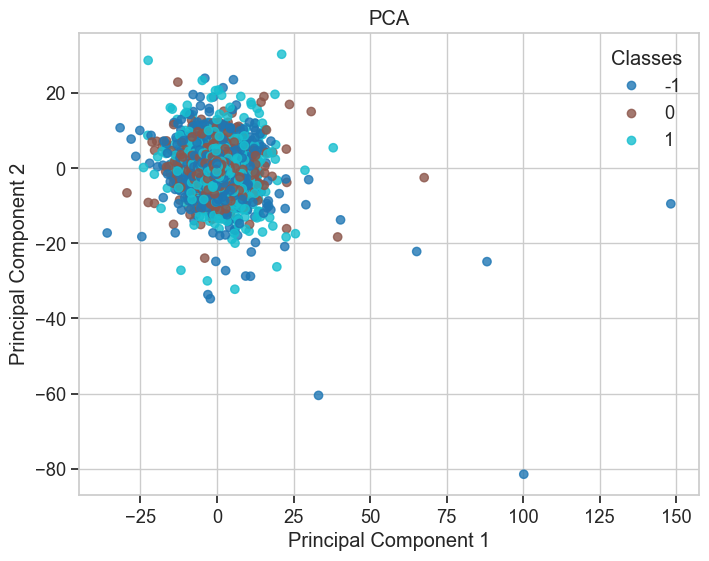

In [ ]:
target = X_train_glb["reod"].values
target

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_glb.loc[:, "day":"r52"].fillna(0).copy(deep=True))

pca = PCA(n_components=2)
data_pca = pca.fit_transform(X_train_standardized)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=target, cmap=plt.cm.get_cmap('tab10', 3), alpha=0.8)
plt.legend(handles=scatter.legend_elements()[0], labels=['-1', '0', '1'], title="Classes")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(X_train_glb.fillna(0))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=target, cmap=plt.cm.get_cmap('tab10', 3), alpha=0.8)
plt.legend(handles=scatter.legend_elements()[0], labels=['-1', '0', '1'], title="Classes")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('t-SNE')
plt.show()

### Uniform Manifold Approximation and Projection (UMAP)

In [ ]:
from umap import UMAP

umap_model = UMAP(n_components=2, random_state=42)
data_umap = umap_model.fit_transform(X_train_glb.fillna(0))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_umap[:, 0], data_umap[:, 1], c=target, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Digit Label')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP')
plt.show()

## Ce que nous comptons faire

# Project Plan: Data Imputation and Modeling Pipeline

---

## Phase 1: Data Preparation and Exploration

- **Complete dataset creation with all imputation strategies**
  - Apply various imputation methods (mean, median, KNN, MICE, interpolation, etc.)
  - Generate separate datasets for each imputation strategy

- **Exploratory Data Analysis (EDA) for each imputed dataset**
  - Analyze **distribution of values** post-imputation (histograms, KDE plots)
  - Examine **correlation structures** using heatmaps and correlation matrices
  - Investigate **class distributions** to ensure consistency and balance across imputations

---

## Phase 2: Feature Analysis

- **Feature importance analysis using XGBoost/LightGBM**
  - Rank features based on gain, cover, and frequency
  - Identify features with high predictive power across imputations

- **Dimensionality reduction with PCA**
  - Visualize data in lower dimensions
  - Assess variance explained by principal components
  - Identify clusters or patterns that inform feature interactions

- **Correlation analysis to identify redundant features**
  - Remove highly correlated features to reduce multicollinearity
  - Use hierarchical clustering on correlation matrix to group similar features

- **Create optimal feature sets based on analyses**
  - Select features with high importance and low redundancy
  - Maintain feature sets tailored to each imputation strategy

---

## Phase 3: Baseline Model Experiments

- **Train simple models (XGBoost, Logistic Regression) on each dataset**
  - Use consistent training/validation split across imputations
  - Log accuracy, AUC, F1-score, and training times

- **Compare imputation strategies based on model performance**
  - Rank imputation methods according to model accuracy and stability
  - Identify potential biases or degradations introduced by imputations

- **Identify most promising datasets and feature combinations**
  - Select top N configurations for advanced modeling

---

## Phase 4: Advanced Modeling

- **Hyperparameter tuning for best-performing models**
  - Grid search / Bayesian optimization for parameters (e.g., learning rate, depth, regularization)
  - Use cross-validation to prevent overfitting

- **Ensemble methods combining predictions from different imputation strategies**
  - Voting classifiers, stacking, and blending
  - Evaluate robustness of ensembles compared to individual models

- **Cross-validation to ensure robustness of results**
  - Use stratified k-fold CV
  - Assess variance and generalizability

- **Learning curves to determine if more data would help**
  - Plot training vs. validation error across sample sizes
  - Decide whether data augmentation or collection is needed

---

## Phase 5: Deep Learning Experiments (if appropriate)

- **Neural network architectures for time series classification**
  - Dense networks, convolutional layers, etc.

- **Sequence models (LSTM/GRU) to capture temporal dependencies**
  - Explore recurrent models for sequence prediction
  - Compare with tree-based models

- **Compare with traditional ML models**
  - Assess whether deep learning adds significant performance improvement
  - Evaluate cost-benefit tradeoffs

---

## Phase 6: Explainability and Analysis

- **SHAP values to explain model predictions**
  - Global and local explainability
  - Visualize contributions of each feature to predictions

- **Error analysis to identify challenging cases**
  - Investigate misclassified examples
  - Segment errors by class, time, or feature ranges

- **Feature impact visualization to understand importance of imputation strategies**
  - Analyze how imputations influence top predictive features
  - Map errors or instability to imputation-induced noise

---

## Phase 7: Final Model Selection and Deployment

- **Performance-speed tradeoff analysis**
  - Evaluate latency, memory, and computational costs
  - Consider deployment constraints

- **Select optimal model based on accuracy, speed, and explainability**
  - Choose model that balances performance with interpretability

- **Document findings about best imputation strategies**
  - Summarize advantages, disadvantages, and impacts of each method

- **Create final pipeline for processing new data**
  - Implement preprocessing, imputation, feature selection, model inference
  - Ensure reproducibility and scalability

---

## Additional Recommendations

- **Start small**  
  Begin with a subset of data to quickly iterate and validate approaches.

- **Visualize throughout**  
  Use visualizations at each step to guide intuition and detect anomalies.

- **Track experiments thoroughly**  
  Log all hyperparameters, imputation methods, model results, and timings.

- **Consider multi-stage models**  
  Use different models or strategies for distinct market conditions or segments.

- **Leverage domain-specific features**  
  Engineer features capturing momentum, volatility, mean-reversion, and other market dynamics.


Nous allons explorer plusieurs approches afin d'optimiser notre pipeline de prédiction. Voici notre plan d'expérimentation et d'optimisation :

1. **Création de plusieurs jeux de données :**  
   - **Dataset complet :** Conserver toutes les observations, même celles contenant des valeurs manquantes (NA).  
   - **Dataset filtré :** Retirer les lignes où plus de 30% des colonnes présentent des NA.
   - **Stratégies d'imputation :** Tester différentes méthodes pour compléter les valeurs manquantes, telles que :
     - Interpolation linéaire.
     - Imputation par KNN.
     - Imputation par stratégie simple (moyenne, médiane, etc.).

2. **Feature Engineering et Encodage :**  
   - **Extraction de statistiques à partir des rendements :** Calculer, par exemple, la moyenne, l'écart-type, la somme cumulée, etc.
   - **Exploitation des variables catégorielles `equity` et `day` :**  
     - Pour `equity` : Extraire des agrégats (moyenne historique, volatilité, etc.) pour construire un "profil" de l'action.
     - Pour `day` : Extraire des caractéristiques globales (tendance générale du marché, effet de la veille, etc.) qui pourraient influencer la performance du jour. (calculer le nombre moyen de mouvement haussier pour un jour, mouvement baissier, neutre...) --> Permettrait de mettre en avant un effet bullish ou bearish. 
   - Comparer l’impact de ces transformations sur les performances du modèle.
   Concernant l'encodage : nous n'avons pas encore trouvé de manière d'encoder les variables equity et day en tant que tel à part en calculant des statistiques / caractéristiques globales

3. **Essais avec des modèles simples :**  
   - Développer des modèles de base (XGBoost) sur chacun des jeux de données préparés.
   - Évaluer les performances à l’aide de métriques telles que l’accuracy et la matrice de confusion.
   - Vérifier l’impact des différentes stratégies d’imputation sur les résultats.

4. **Passage à des modèles plus complexes :**  
   - Utiilisation de réseaux de neurones : LSTM ou un simple MLP.

5. **Optimisation des hyperparamètres :**  
   - Utiliser la validation croisée (k-fold) pour obtenir une estimation robuste de la performance.
   - Mettre en place une recherche d’hyperparamètres (avec GridSearchCV ou RandomizedSearchCV) pour optimiser :
     - Le taux d’apprentissage (`learning_rate`).
     - Le nombre d’arbres (`n_estimators`).
     - La profondeur maximale (`max_depth`).
     - Les taux de subsampling, etc.
